# SOAP analysis of Si trajectory

This notebook shows how to perform a SOAP analysis of a Si trajectory.

The MD simulation involves the compression of 10,000 atoms of low-density amorphous silicon (a-Si) from 0-20 GPa,  
similar to that described in [J. Chem. Phys. __157__, 104105 (2022)](https://doi.org/10.1063/5.0099929)

We're going to compare the snapshots from the large-scale MD to some known crystal structures of Si   
to understand the structural changes that occur during compression.

In [1]:
from ase.io import read, write
import os
import pandas as pd
import numpy as np
from share.utilities import read_lammps_log

In [8]:
!tar -xzvf structures/Si_10katom_simulation.xyz.tar.gz

structures/Si_10katom_simulation.xyz


In [8]:
Si_traj = read('structures/Si_10katom_simulation.xyz', ':')
print(Si_traj[0])

Atoms(symbols='Si10000', pbc=True, cell=[59.0629, 59.0629, 59.0629], masses=...)


In [2]:
thermo = read_lammps_log('structures/log_npt_Si_mtp.dat')
thermo.head()

,Step,CPU,Temp,f_TempAve,Press,f_PressAve,f_PEAve_Atom,Volume,f_vAve,c_MSD[4]
0,0.0,0.000000,500.00000,0.00000,200.47885,0.000000,0.00000,206036.57,0.00,0.000000
2,1000.0,66.406337,499.06923,496.43517,469.56218,-0.746819,-162.92661,205947.39,206035.67,0.099112
3,2000.0,132.756830,504.12737,500.23940,367.79051,-41.270840,-162.92650,205852.77,206019.93,0.104916
4,3000.0,199.107770,498.82079,500.74544,108.73607,-61.930008,-162.92650,206026.93,206014.29,0.102298
5,4000.0,265.756330,499.03487,499.13229,-185.78896,-85.978728,-162.92618,206067.84,206029.74,0.103973


# Create reference crystal structures

In [5]:
from ase.lattice.hexagonal import Hexagonal
from ase.build import bulk
from ase import Atoms

In [6]:
diamond = bulk('Si', 'diamond', a=5.43)
simple_hexagonal = Atoms(Hexagonal(symbol='Si', latticeconstant={'a': 1.798, 'c':2.411}))
diamond, simple_hexagonal

(Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.715, 2.715], [2.715, 0.0, 2.715], [2.715, 2.715, 0.0]]),
 Atoms(symbols='Si', pbc=True, cell=[[1.798, 0.0, 0.0], [-0.8989999999999996, 1.5571136760044209, 0.0], [0.0, 0.0, 2.411]]))

In [173]:
# In case you want to visualise them with Ovito https://www.ovito.org/manual/installation.html
write('structures/Si_diamond.xyz', diamond)
write('structures/Si_simple_hexagonal.xyz', simple_hexagonal)

<font size= "6">Reference structures<font size= "4">

<img src="images/dia_crystal.png" style="width:400px;height:400px;"><img src="images/sh_crystal.png" style="width:400px;height:400px;">   

Visualisation using [Ovito](https://www.ovito.org/)

# Set up SOAP descriptor

In [ ]:
from quippy.descriptors import Descriptor

In [ ]:
soap_descriptor_str = ('soap l_max=3 n_max=6 ' # basis function size
                       'atom_sigma=0.5 cutoff=5.0 ' # smoothness and cutoff (Angstrom) 
                       'average=T') # average descriptor over whole cell, or one for each atom
soap_cell_average = Descriptor(soap_descriptor_str)
soap_atomistic = Descriptor(soap_descriptor_str.replace('average=T', 'average=F'))

# Create SOAP vectors for each structure

In [38]:
# calculate every 5th structure to speed things up (will take up to 5 mins)
average_descriptor = soap_cell_average.calc_descriptor(Si_traj[::5])
atomistic_descriptor = soap_atomistic.calc_descriptor(Si_traj[::5])

In [10]:
diamond_descriptor = soap_cell_average.calc_descriptor(diamond)
simple_hexagonal_descriptor = soap_cell_average.calc_descriptor(simple_hexagonal)

In [11]:
simple_hexagonal_descriptor.shape  # SOAP vector length

(1, 145)

# Calculate SOAP kernel matrix

In [12]:
zeta = 4  # exponent for the kernel

# calculate dot products (einsum makes dealing with varying shapes of array easier)
k_dia_av = np.einsum('i...j,k...j', average_descriptor, diamond_descriptor).squeeze()**zeta
k_dia_atomistic = np.einsum('i...j,k...j', atomistic_descriptor, diamond_descriptor).squeeze()**zeta


In [13]:
k_simple_hexagonal_av = np.einsum('i...j,k...j', average_descriptor, simple_hexagonal_descriptor).squeeze()**zeta
k_simple_hexagonal_atomistic = np.einsum('i...j,k...j', atomistic_descriptor, simple_hexagonal_descriptor).squeeze()**zeta

In [14]:
k_dia_av = k_dia_av.squeeze()
k_simple_hexagonal_av = k_simple_hexagonal_av.squeeze()

In [15]:
k_dia_av.squeeze().shape # one similarity value for each structure in the trajectory

(51,)

# Pressure vs. similarity

In [16]:
import matplotlib.pyplot as plt
plt.style.use('./share/plot.mplstyle')

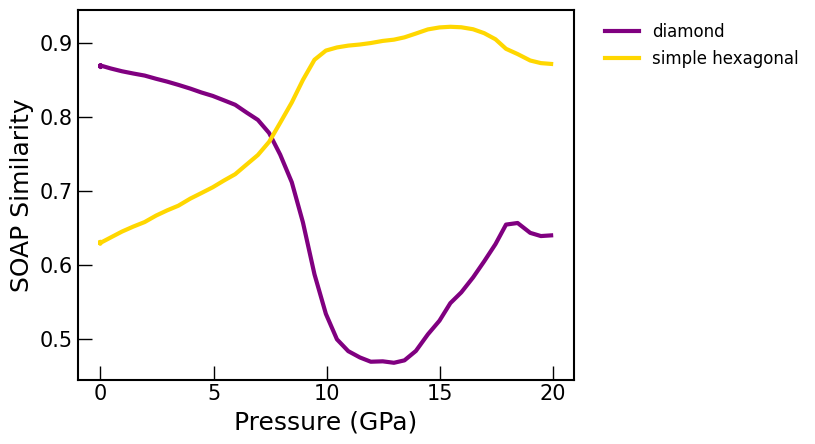

In [17]:
fig, axs = plt.subplots()


pressure_Gpa = thermo['f_PressAve'][::5]/1e4
axs.plot(pressure_Gpa, k_dia_av, label='diamond', c='purple')
axs.plot(pressure_Gpa, k_simple_hexagonal_av, label='simple hexagonal', c='gold')

axs.set(xlabel='Pressure (GPa)', ylabel='SOAP Similarity')
axs.legend(loc='upper left', bbox_to_anchor=(1, 1.05), frameon=False)

# Label each atom with similarity
to reference structures for visualisation in Ovito

In [18]:
k_dia_atomistic.shape

(10000, 51)

In [22]:
len(Si_traj[::5])

51

In [28]:
for ct, i in enumerate(range(0,len(Si_traj),5)):
    Si_traj[i].arrays['k_dia'] = k_dia_atomistic[:, ct]
    Si_traj[i].arrays['k_simple_hexagonal'] = k_simple_hexagonal_atomistic[:, ct]

In [29]:
Si_traj[0].arrays['k_dia'][:10]

array([0.91818053, 0.71201282, 0.85485859, 0.77155732, 0.94632169,
       0.85607522, 0.80206024, 0.96063755, 0.78245453, 0.9570341 ])

In [30]:
write('structures/Si_traj_SOAPlabelled.xyz', Si_traj[::5]) # write 1/5th of the trajectory to save on memory

<img src="images/dia.png" style="width:400px;height:400px;"><img src="images/10GPa.png" style="width:400px;height:400px;"><img src="images/sh.png" style="width:400px;height:400px;">


Visualisation using [Ovito](https://www.ovito.org/)

# Plot simple 2D sketch map

in the style of [Phys. Chem. Chem. Phys., 2016, __18__, 13754-13769](https://doi.org/10.1039/C6CP00415F)

In [31]:
from sklearn.decomposition import KernelPCA
import matplotlib as mpl

In [32]:
k_self_av = np.einsum('i...j,k...j', average_descriptor, average_descriptor).squeeze()**zeta
distance_matrix = np.sqrt(np.clip(2 - 2*k_self_av, a_min=0, a_max=None))

In [33]:
kpca = KernelPCA(n_components=2)
kpca.fit(distance_matrix)
x, y = kpca.fit_transform(distance_matrix).T

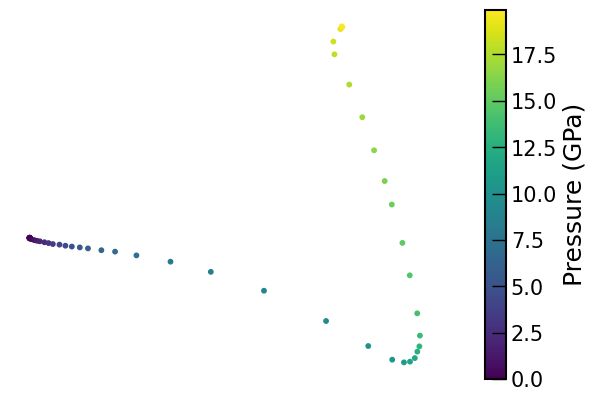

In [36]:
fig, axs = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 0.05]})

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=pressure_Gpa.min(), vmax=pressure_Gpa.max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

axs[0].scatter(x, y, c=pressure_Gpa, cmap=cmap, s=10, marker='o')
axs[0].axis('off')

fig.colorbar(sm, label='Pressure (GPa)', cax=axs[1])

# Exercises

* Use the methods above to explore the dependence of the pressure vs. similarity plot  
on the lattice constant(s) of the diamond and simple hexagonal structures.

* What is the effect of varying the SOAP hyperparameters:  
the `cutoff` and the smoothness (`atom_sigma`)?

* Perform a similar analysis for the carbon trajectory from the previous notebook